## Library Imports

In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df_seg = pd.read_csv('segmentation data.csv', index_col=0)

## Summary

In [3]:
df_seg.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_seg.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## Visualization

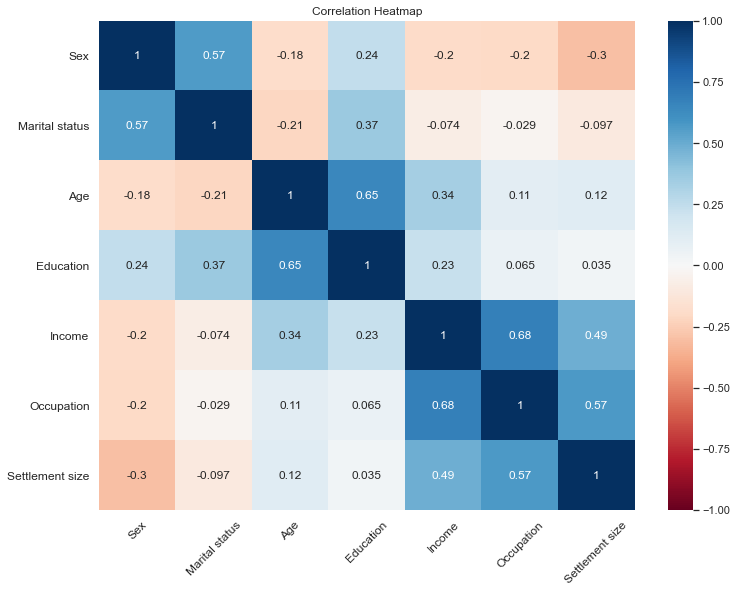

In [5]:
plt.figure(figsize=(12,9))

s = sns.heatmap(df_seg.corr(),
            annot=True,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu')
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize=12)
s.set_xticklabels(s.get_xticklabels(), rotation = 45, fontsize=12)
plt.title('Correlation Heatmap')
plt.show()

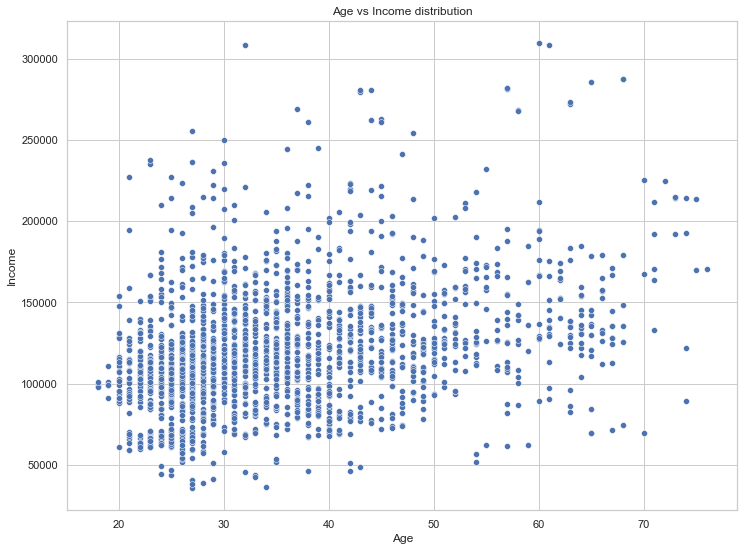

In [6]:
plt.figure(figsize=(12,9))
sns.set_style('whitegrid')
sns.scatterplot(x = df_seg['Age'],y = df_seg['Income'])
plt.title('Age vs Income distribution')
plt.show()

*It would be a better idea to club numerical variables and plot summary of the data.*

## Standardization

*Used standardization to scale the data to a similar min-max value*

In [10]:
scale = RobustScaler()
df_seg_prep = scale.fit_transform(df_seg)

## Clustering Methods
---
   ### Hierarchical

In [15]:
 hier_clust = linkage(df_seg_prep, method='ward')

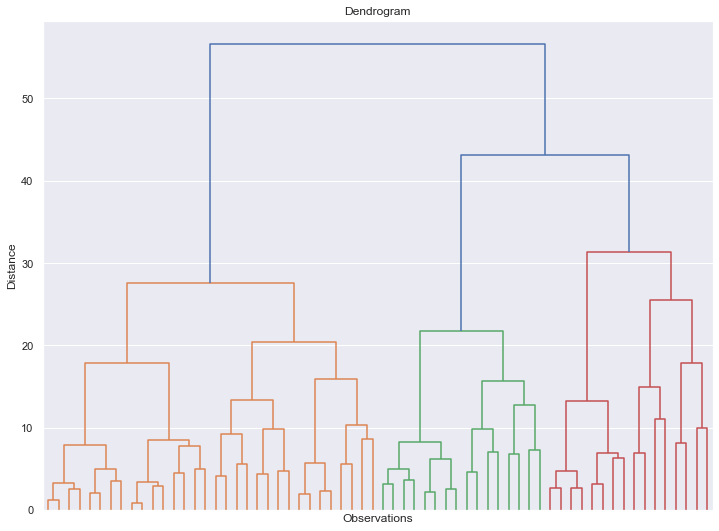

In [21]:
plt.figure(figsize=(12,9))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(hier_clust,
           truncate_mode='level',p=5,
          show_leaf_counts=False,
          no_labels=True)
plt.show()

1. *Hierarchical clustering is slow and may take hours if we have a large dataset.* 
2. *It almost always generates/predicts the number of clusters, we can use that number on flat clustering methods for big data.*
---
### K-means

In [24]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
    kmeans.fit(df_seg_prep)
    wcss.append(kmeans.inertia_)

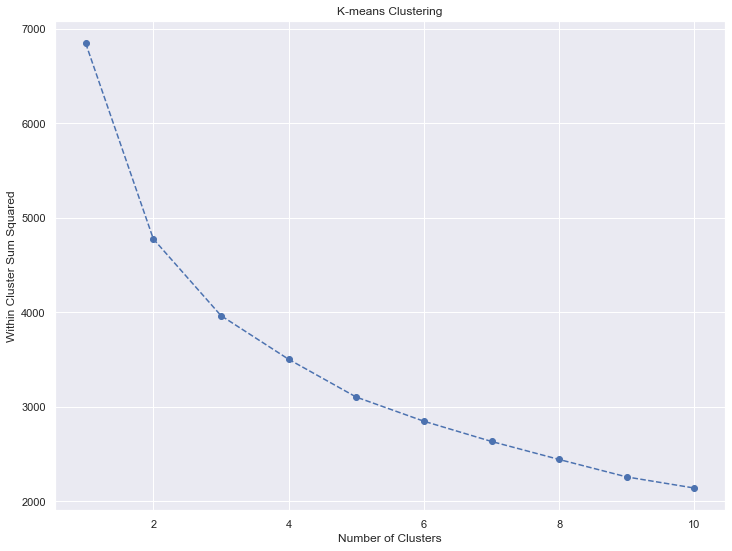

In [26]:
plt.figure(figsize=(12,9))
plt.title('K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Squared')
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.show()

*From the plot above,
To select the number of clusters for K-means clustering, we select the elbow of the graph. i.e Check where our curve smooths after a steep drop.*

***Based on our results from K-means and Hierarchical clustering, we can either select 3 or 4 clusters***

In [27]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=10)
kmeans.fit(df_seg_prep)

KMeans(n_clusters=4, random_state=10)

## Results

In [29]:
seg_res = df_seg.copy()
seg_res['Segment'] = kmeans.labels_

In [33]:
df_analysis = seg_res.groupby(['Segment']).mean()
df_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment,,,,,,,
0,0.599034,0.521739,30.932367,0.844203,96745.560386,0.397343,0.007246
1,0.331395,0.470930,31.665698,0.824128,124660.145349,1.103198,1.434593
2,0.237069,0.375000,45.827586,1.379310,193374.818966,1.668103,1.504310
3,0.535714,0.595238,54.714286,1.944444,123707.841270,0.579365,0.539683


***Segments***

0. *Fewer Opportunities*
1. *Standard*
2. *Career Focused*
3. *Old*

In [37]:
df_analysis['n_obs'] = seg_res[['Segment','Sex']].groupby(['Segment']).count()
df_analysis['prop'] = df_analysis['n_obs'] / df_analysis['n_obs'].sum() 

In [38]:
df_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,n_obs,prop
Segment,,,,,,,,,
0,0.599034,0.521739,30.932367,0.844203,96745.560386,0.397343,0.007246,828,0.414
1,0.331395,0.470930,31.665698,0.824128,124660.145349,1.103198,1.434593,688,0.344
2,0.237069,0.375000,45.827586,1.379310,193374.818966,1.668103,1.504310,232,0.116
3,0.535714,0.595238,54.714286,1.944444,123707.841270,0.579365,0.539683,252,0.126


In [40]:
df_analysis.rename({0:'Fewer Opportunities',1:'Standard',
                    2:'Career Focused',3:'Old'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,n_obs,prop
Segment,,,,,,,,,
Fewer Opportunities,0.599034,0.521739,30.932367,0.844203,96745.560386,0.397343,0.007246,828,0.414
Standard,0.331395,0.470930,31.665698,0.824128,124660.145349,1.103198,1.434593,688,0.344
Career Focused,0.237069,0.375000,45.827586,1.379310,193374.818966,1.668103,1.504310,232,0.116
Old,0.535714,0.595238,54.714286,1.944444,123707.841270,0.579365,0.539683,252,0.126


In [43]:
seg_res['labels'] = seg_res['Segment'].map({0:'Fewer Opportunities',1:'Standard',
                    2:'Career Focused',3:'Old'})

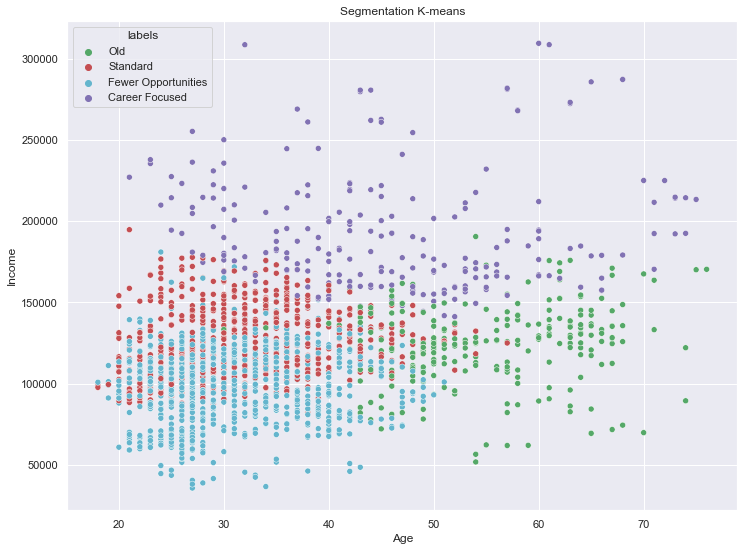

In [45]:
x_axis = seg_res['Age']
y_axis = seg_res['Income']

plt.figure(figsize=(12,9))
sns.scatterplot(x=x_axis,y=y_axis, hue=seg_res['labels'],
               palette=['g','r','c','m'])
plt.title('Segmentation K-means')
plt.show()

***Output***

1. *Career Focused/ Old are better segmented, but the other two groups overlap.*
2. *K-means did a reasonable job at segmentation however the result is far from perfect.*

## Dimensionality Reduction using PCA

In [47]:
pca = PCA()
pca.fit(df_seg_prep)

PCA()

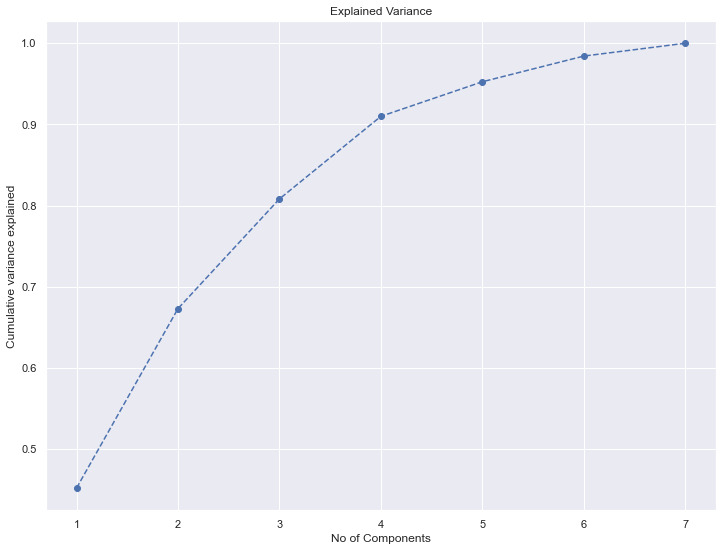

In [49]:
plt.figure(figsize=(12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(),
        marker ='o', linestyle='--')
plt.title('Explained Variance')
plt.xlabel('No of Components')
plt.ylabel('Cumulative variance explained')
plt.show()

In [50]:
pca = PCA(n_components=4)
pca.fit(df_seg_prep)

PCA(n_components=4)

## PCA Results

In [52]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                          columns=df_seg.columns.values,
                          index=['Component 1','Component 2',
                                'Component 3', 'Component 4'])

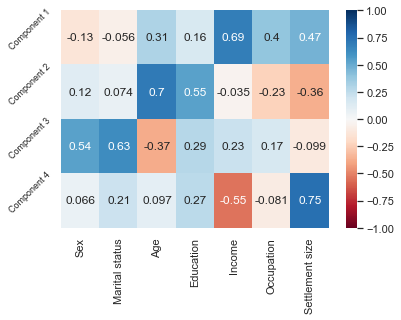

In [55]:
sns.heatmap(df_pca_comp,
           vmin=-1, vmax=1,
           cmap='RdBu',
           annot=True)
plt.yticks([0,1,2,3], 
          ['Component 1','Component 2','Component 3', 'Component 4'],
          rotation =45, 
          fontsize =9)
plt.show()

In [56]:
scores_pca = pca.transform(df_seg_prep)